The files in this directory include:

regInterFullFiltered.html - A listing of all the interactions in the data in an HTML table.
 
coliInterFullVec.txt - All interactions in the dataset listed as a three column vector (operon number, transcription factor number, regulation type (1 activator, 2 repressor, 3 dual)).

coliInterNoAutoRegVec.txt - A binary (unsigned) version of coliInterFullVec only without autoregulation interactions.

coliInterFullNames.txt - A two column vector, the first column is a number, matching the number of the first two columns of the above interaction files, and the second column is the name of the operon.

RegulonDB data is of version 3.2 XML version with the unknown interactions, and the chip only interactions (00001) NOT included.
All other data collected by Shai Shen-Orr under the supervision of Dr. Uri Alon

There are 578 interactions in the matrix (519 with no autoregulation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy
import sklearn
from IPython.display import Image
%matplotlib inline

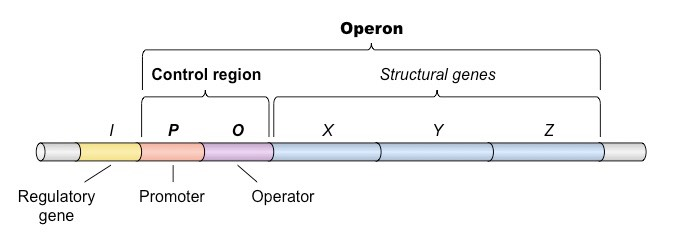

In [2]:
display(Image('operon_med.jpg'))

In bacteria, genes are rarely expressed (transcribed into proteins) on their own. Often, genes are expressed together, and groups of genes that are controlled together are known as operons. An operon's expression can be increased (output of proteins goes up) or decreased by proteins known as transcription factors. Transcription factors (TFs) will bind to a section of DNA just before the start of an operon and either increase or decrease the expression levels of that operon. 

Activators are TFs that only increase expression levels.
Repressors are TFs that only decrease expression levels.
There are TFs that can perform both functions, and those are known as dual TFs.

Operons rarely function on their own. Transcriptional regulation networks are how operons interact with one other and orchestrate gene expression for the cell. These interconnected networks allow for changes in the expression of multiple operons from a single expression change specific central operons.

We have several key questions regarding this E.coli network:

1. Are most of the genes in the network interconnected or separate?
2. Which genes are the most central to the network?
3. How does the distribution of TF classes play out in E. coli?

In [3]:
#import table with names of genes
names = pd.read_table('colinet/coliInterFullNames.txt', sep=' ', header=None)
names.columns = ['id', 'gene']

#import table containing all interactions
full_vec = pd.read_table('colinet/coliInterFullVec.txt', sep=' ', header=None)
full_vec.columns = ['operon_number', 'transcription_number', 'regulation_type']
full_vec['regulation_type'] = full_vec['regulation_type'].replace([1, 2, 3], ['activator', 'repressor', 'dual'])

#import names of operons and transcrption factors
operons = pd.read_csv('colinet/operon_names.csv')
operons.columns = ['transcripion_name', 'operon_name']
names = names.join(operons)

#merge the two tables on the indexes
df = names.merge(full_vec, left_index=True, right_index=True)

print(df.shape)
df.head()

(423, 7)


,id,gene,transcripion_name,operon_name,operon_number,transcription_number,regulation_type
0,1,aceBAK,AcrR,acrAB,3,4,repressor
1,2,acnA,Ada,ada-alkB,6,6,dual
2,3,acrAB,Ada,aidB,11,6,activator
3,4,acrR,Ada,alkA,14,6,activator
4,5,acs,AdiY,adiA,8,9,activator


In [4]:
#print the number of unique variables in each feature
for col in df:
    print('Unique '+ col + ' variables:', df[col].nunique())

Unique id variables: 423
Unique gene variables: 423
Unique transcripion_name variables: 88
Unique operon_name variables: 280
Unique operon_number variables: 272
Unique transcription_number variables: 87
Unique regulation_type variables: 3


In [5]:
#create a list of tuples between the operon and transcription numbers
tuples = [(x[4], x[5]) for x in df.values]

#create a blank network graph
G = nx.Graph()

#fill the network graph with the tuple list as edges
G.add_edges_from(tuples)

In [6]:
#add attributes to the nodes in the graph
for node in df['id']:
    if node in G.nodes():
        G.node[node]['Gene'] = df.loc[df['id']==node,'gene'].values[0]
        G.node[node]['Regulation Type'] = df.loc[df['id']==node,'regulation_type'].values[0]
        G.node[node]['Transcription Factor Name'] = df.loc[df['id']==node,'transcripion_name'].values[0]
        G.node[node]['Operon Name'] = df.loc[df['id']==node,'operon_name'].values[0]

#view the attributes of node 10        
print('Node 10: ', G.nodes[10])

Node 10:  {'Gene': 'ahpCF', 'Regulation Type': 'dual', 'Transcription Factor Name': 'AraC', 'Operon Name': 'araE'}


In this network map, the nodes are operons and the edges are the trancription factors.

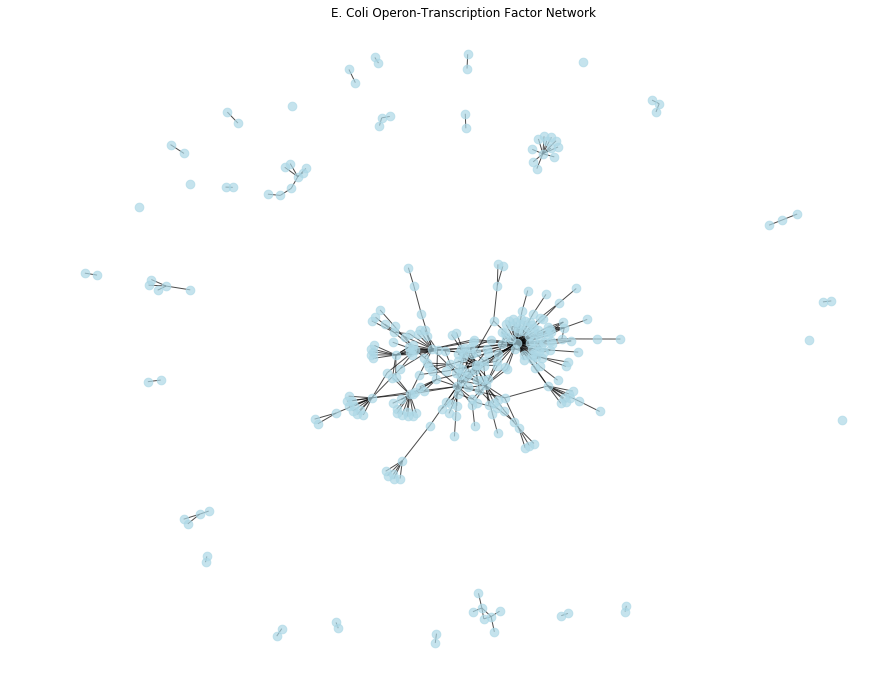

In [7]:
#draw the complete network graph
plt.figure(figsize=(15, 12))
nx.draw_networkx(G,
                 pos=nx.spring_layout(G), 
                 node_color='lightblue',
                 edge_color='black',
                 node_size=75,
                 with_labels=False,
                 alpha=.7
                 )
plt.title('E. Coli Operon-Transcription Factor Network')
plt.axis('off')
plt.show()

In [8]:
#gather network statistics and print a few
number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()
node_dict = dict(G.degree())
node_degrees = list(node_dict.values())
avg_degree = np.mean(node_degrees)
med_degree = np.median(node_degrees)
max_degree = max(node_degrees)
clustering = list(nx.clustering(G).values())
betweenness_cent = list(nx.betweenness_centrality(G).values())
component_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

print("This graph has {} nodes and {} edges.".format(number_of_nodes, number_of_edges))
print("The median degree is {} and the mean degree is {}.".format(med_degree, avg_degree))
print("A disease node with median degree is connected to {}% of other operons.".format((med_degree/number_of_nodes)*100))
print("The disease node with the maximum degree is connected to {}% of other operons.".format((max_degree/number_of_nodes)*100))
print("There are {} connected components within the graph.".format(nx.number_connected_components(G)))

This graph has 309 nodes and 423 edges.
The median degree is 1.0 and the mean degree is 2.737864077669903.
A disease node with median degree is connected to 0.3236245954692557% of other operons.
The disease node with the maximum degree is connected to 23.948220064724918% of other operons.
There are 31 connected components within the graph.


In [9]:
#print the node attributes for nodes with a degree greater than 10
for degree in G.degree():
    if degree[1] >= 10:
        print('Node '+ str(degree[0])+' with a degree of ' + str(degree[1]) + ':')
        print('\t', G.node[degree[0]])

Node 24 with a degree of 21:
	 {'Gene': 'arcA', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'glcDEFGB'}
Node 64 with a degree of 12:
	 {'Gene': 'cpxAR', 'Regulation Type': 'activator', 'Transcription Factor Name': 'CRP', 'Operon Name': 'acs'}
Node 66 with a degree of 74:
	 {'Gene': 'crp', 'Regulation Type': 'activator', 'Transcription Factor Name': 'CRP', 'Operon Name': 'ansB'}
Node 136 with a degree of 10:
	 {'Gene': 'flhDC', 'Regulation Type': 'activator', 'Transcription Factor Name': 'CRP', 'Operon Name': 'yiaKLMNOPQRS'}
Node 154 with a degree of 12:
	 {'Gene': 'fur', 'Regulation Type': 'dual', 'Transcription Factor Name': 'CytR', 'Operon Name': 'tsx'}
Node 193 with a degree of 10:
	 {'Gene': 'hns', 'Regulation Type': 'activator', 'Transcription Factor Name': 'FIS', 'Operon Name': 'leuX'}
Node 137 with a degree of 16:
	 {'Gene': 'fliAZY', 'Regulation Type': 'activator', 'Transcription Factor Name': 'CsgD', 'Operon Name': 'csgBA'}
Node 143 with

The nodes with the highest degrees have transcription factors and genes associated with the most vital aspects of cellular life. ArcA, CRP, CysB, GalR, and GlcC all play critical roles in cellular metabolism. CytR controls the transportation of nucleic material (material that makes up DNA and RNA) through the cell. FIS produces a precursor protein which makes transcription factors, which control gene expression. FliA produces the proteins that give E.coli the ability to move. CsgD produces bio-film, a substance that helps E.coli bind together and protects E.coli in harsher environments.

CRP produces a molecule known as cAMP, the building block of ATP which is what E.coli uses to power the majority of intracellular functions. Nearly everything in the bacteria utilizes cAMP in one way or another.

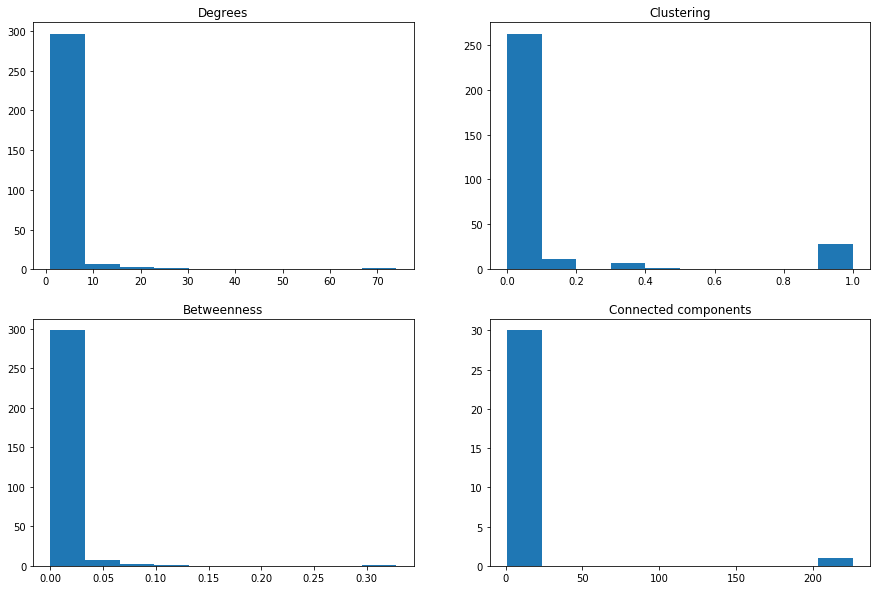

In [10]:
#display network statistics as histograms to view distributions
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.hist(node_degrees)
plt.title('Degrees')

plt.subplot(222)
plt.hist(clustering)
plt.title('Clustering')

plt.subplot(223)
plt.hist(betweenness_cent)
plt.title('Betweenness')

plt.subplot(224)
plt.hist(component_sizes)
plt.title('Connected components')
plt.show()

As you can see, the majority of our nodes are not connected to many other nodes, with a massive outlier at 74. The majority of our nodes are not culusterd together, with one expection. It appears as though our nodes are either very sparsly connected, or highly clustered. There is little in between. We confirm what we visually saw above, that there is one, highly interconnected node.

In [11]:
#pull our node-level statistics together into a dataframe
graph_stats=pd.DataFrame({'node':list(dict(G.degree()).keys()),
                          'degree':list(dict(G.degree()).values()),
                          'clustering':list(nx.clustering(G).values()),
                          'betweenness_cent':list(nx.betweenness_centrality(G).values()),
                          'degree_cent':list(nx.degree_centrality(G).values())
                         })

#assign each node to a component by number
graph_stats['component']=None
graph_stats['regulation_type'] = df['regulation_type']

#sort the components by size so that the largest component will be numbered 0
components=sorted(nx.connected_components(G), key=len, reverse=True)
for i,component in enumerate(components):
    graph_stats.loc[graph_stats['node'].isin(list(component)),'component']=i
    
graph_stats.head()

,node,degree,clustering,betweenness_cent,degree_cent,component,regulation_type
0,3,1,0.0,0.000000,0.003247,9,repressor
1,4,1,0.0,0.000000,0.003247,9,dual
2,6,4,0.0,0.004738,0.012987,0,activator
3,11,1,0.0,0.000000,0.003247,0,activator
4,14,2,0.0,0.009434,0.006494,0,activator


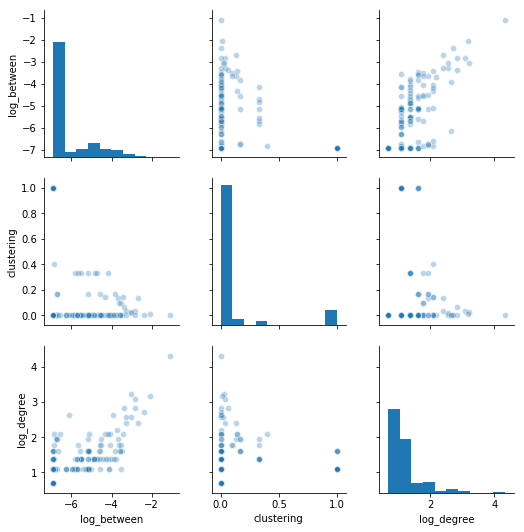

In [12]:
#log the betweenness centrality and degree for easier relationship viewing
graph_stats['log_between']=np.log(graph_stats['betweenness_cent']+.001)
graph_stats['log_degree']=np.log(graph_stats['degree']+1)

g = sns.pairplot(graph_stats,
                 vars=['log_between','clustering','log_degree'],
                 kind='scatter',
                plot_kws={'alpha':.3})
plt.show()

The relationship between degree, clustering, and betweenness centrality all confirm that there is a core cluster of major players and then sparesly connected networks.

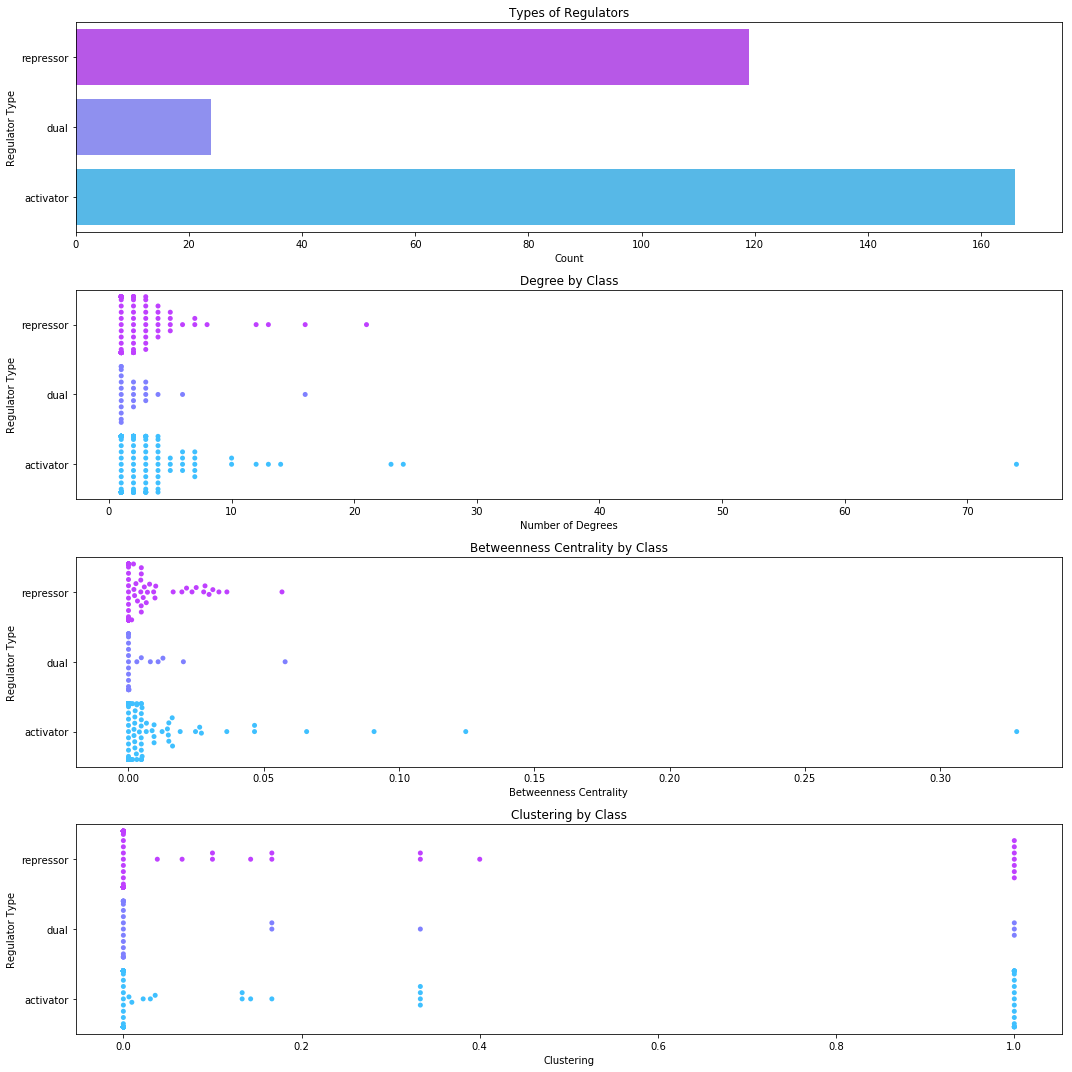

In [13]:
#plot the distribution of network statistics by the regulator type
plt.figure(figsize=(15, 15))

plt.subplot(411)
sns.countplot(y='regulation_type', data=graph_stats, orient='h', palette='cool_r')
plt.ylabel('Regulator Type')
plt.xlabel('Count')
plt.title('Types of Regulators')

plt.subplot(412)
sns.swarmplot(x='degree', y='regulation_type', data=graph_stats, palette='cool_r')
plt.xlabel('Number of Degrees')
plt.ylabel('Regulator Type')
plt.title('Degree by Class')

plt.subplot(413)
sns.swarmplot(x='betweenness_cent', y='regulation_type', data=graph_stats, palette='cool_r')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Regulator Type')
plt.title('Betweenness Centrality by Class')

plt.subplot(414)
sns.swarmplot(x='clustering', y='regulation_type', data=graph_stats, palette='cool_r')
plt.xlabel('Clustering')
plt.ylabel('Regulator Type')
plt.title('Clustering by Class')


plt.tight_layout()
plt.show()

There appears to be 3 classes of cluster, spare, moderate, and tightly clustered. Also, the outlier cluster is controlled by an activator.

In [14]:
#calculate network statistics for each regulator type and put into a new dataframe
component_df = pd.DataFrame()
component_df['number_nodes'] = graph_stats.groupby('regulation_type')['component'].count()
component_df['connections'] = graph_stats.groupby('regulation_type')['component'].apply(lambda x: len(set(x)))
component_df['connections_normed'] = component_df.connections/component_df.number_nodes
component_df['median_degree'] = graph_stats.groupby('regulation_type')['degree'].median()
component_df['avg_degree'] = graph_stats.groupby('regulation_type')['degree'].mean()
#component_df['count_clusters'] = graph_stats.groupby('regulation_type')['clustering'].count()
component_df['avg_clusters'] = graph_stats.groupby('regulation_type')['clustering'].mean()
#component_df['avg_centrality'] = graph_stats.groupby('betweenness_cent')['clustering'].mean()
component_df

,number_nodes,connections,connections_normed,median_degree,avg_degree,avg_clusters
regulation_type,,,,,,
activator,166,19,0.114458,2.0,3.072289,0.120564
dual,24,6,0.250000,1.5,2.500000,0.152778
repressor,119,20,0.168067,1.0,2.319328,0.074344


In [15]:
#create a list of the regulation type attribute for each node
classlist=list(nx.get_node_attributes(G,'Regulation Type').values())

#set a legend for use in labeling
legend_dictionary={'activator': 0, 'repressor': 1, 'dual': 2}

#create a list that matches the value to the key in the legend
class_list = []
for stuff in classlist:
    for value in legend_dictionary.items():
        if stuff == value[0]:
            class_list.append(value[1])

#build a dictionary of node attributes that matches the legend dictionary
class_dict = dict(zip(list(G.nodes), class_list))

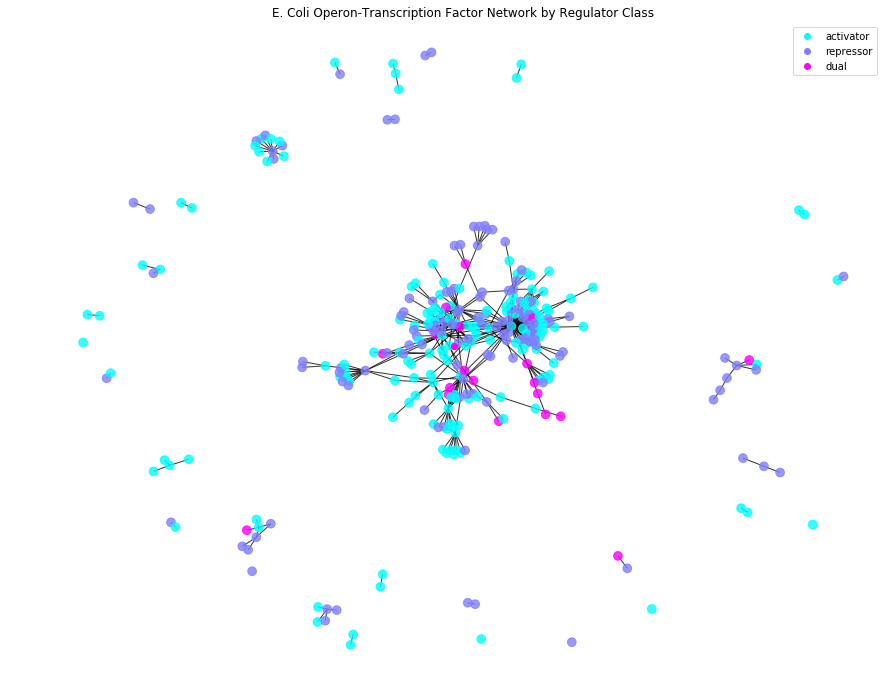

In [16]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
#set the position
pos=nx.spring_layout(G)
#set a value map to the class dictionary created above
val_map = class_dict
#set the color legend to equal the legend dictionary
color_legend = legend_dictionary
values = [val_map.get(node, 0) for node in G.nodes()]
#color mapping
cool = cm = plt.get_cmap('cool')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cool)

#use a f, ax plot to call the plot as a parameter and ax to build a legend
plt.figure(figsize=(15,12))
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in color_legend:
    ax.plot([0],[0],color=scalarMap.to_rgba(color_legend[label]), label=label, marker='o', linewidth=0)

#draw the network map with colored nodes and legend
multi_G = nx.draw_networkx(G,pos, cmap=cool, vmin=0, vmax=max(values), node_color=values, with_labels=False, ax=ax,
                node_size=75, alpha=0.8)

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.title('E. Coli Operon-Transcription Factor Network by Regulator Class')
plt.legend()

plt.show()

In [17]:
#list out all the neighbors of the node with the largest degree, 66
node66 = list(nx.all_neighbors(G, 66))

for node in node66:
    print(str(node) + ':', G.node[node])

5: {'Gene': 'acs', 'Regulation Type': 'activator', 'Transcription Factor Name': 'AdiY', 'Operon Name': 'adiA'}
13: {'Gene': 'aldB', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'aceBAK'}
16: {'Gene': 'ansB', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'betIBA'}
19: {'Gene': 'araBAD', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'dctA'}
20: {'Gene': 'araC', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'fadBA'}
21: {'Gene': 'araE', 'Regulation Type': 'activator', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'focA-pflB'}
22: {'Gene': 'araFG_araH_1H_2', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'fumA'}
23: {'Gene': 'araJ', 'Regulation Type': 'repressor', 'Transcription Factor Name': 'ArcA', 'Operon Name': 'fumC'}
56: {'Gene': 'caiF', 'Regulation Type': 'activator', 'Transcription Factor 

In [18]:
#create dataframes containing unique TF classes
activator = df[df['regulation_type'] == 'activator']
repressor = df[df['regulation_type'] == 'repressor']
dual = df[df['regulation_type'] == 'dual']

tuple_a = [(x[4], x[5]) for x in activator.values]
tuple_r = [(x[4], x[5]) for x in repressor.values]
tuple_d = [(x[4], x[5]) for x in dual.values]

G1 = nx.Graph()
G2 = nx.Graph()
G3 = nx.Graph()

G1.add_edges_from(tuple_a)
G2.add_edges_from(tuple_r)
G3.add_edges_from(tuple_d)

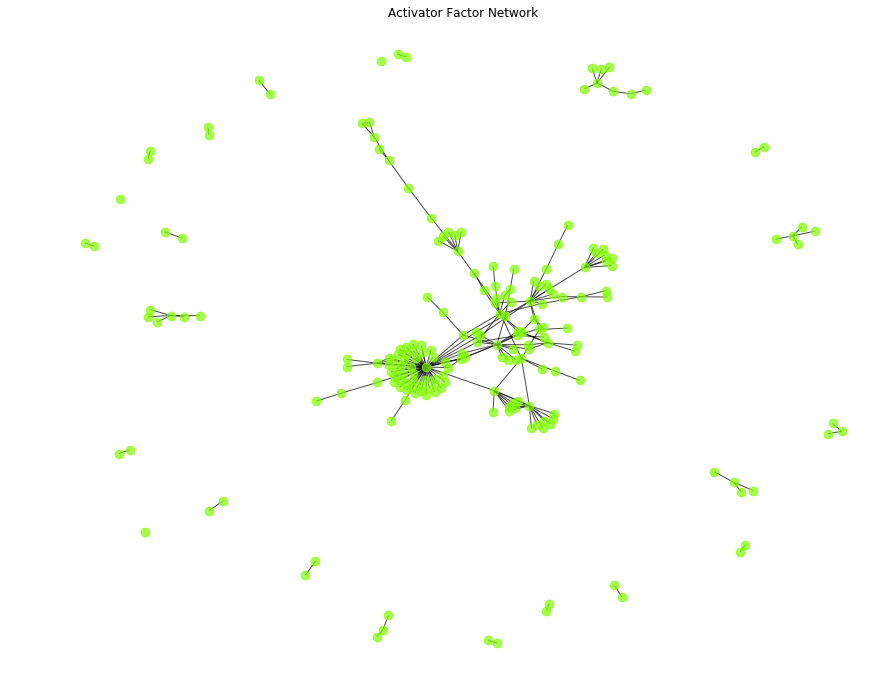

In [19]:
#draw the activator network graph
plt.figure(figsize=(15, 12))
nx.draw_networkx(G1,
                 pos=nx.spring_layout(G1), 
                 node_color='chartreuse',
                 edge_color='black',
                 node_size=75,
                 with_labels=False,
                 alpha=.7
                 )
plt.title('Activator Factor Network')
plt.axis('off')
plt.show()

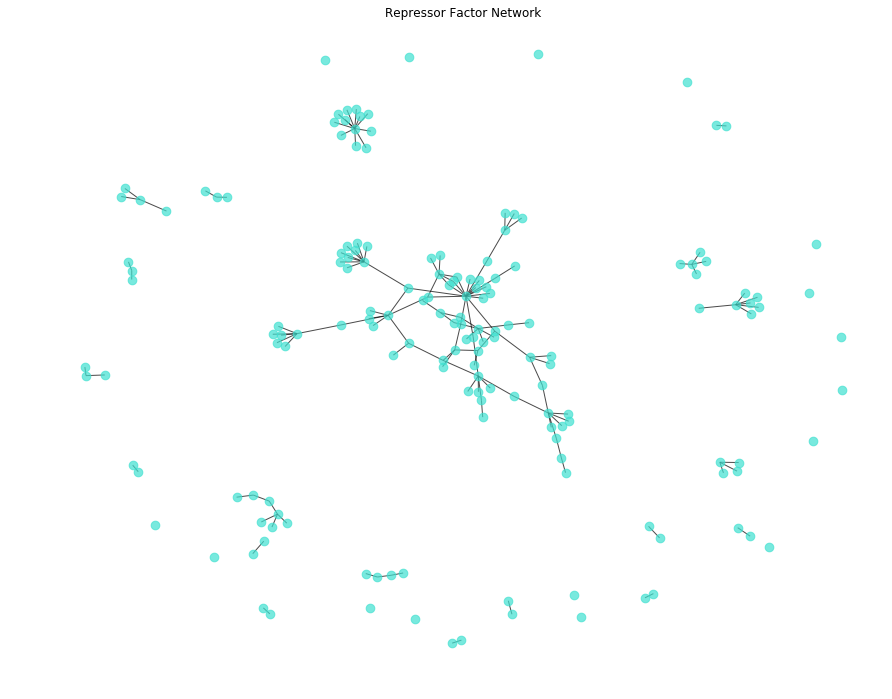

In [20]:
#draw the repressor network graph
plt.figure(figsize=(15, 12))
nx.draw_networkx(G2,
                 pos=nx.spring_layout(G2), 
                 node_color='turquoise',
                 edge_color='black',
                 node_size=75,
                 with_labels=False,
                 alpha=.7
                 )
plt.title('Repressor Factor Network')
plt.axis('off')
plt.show()

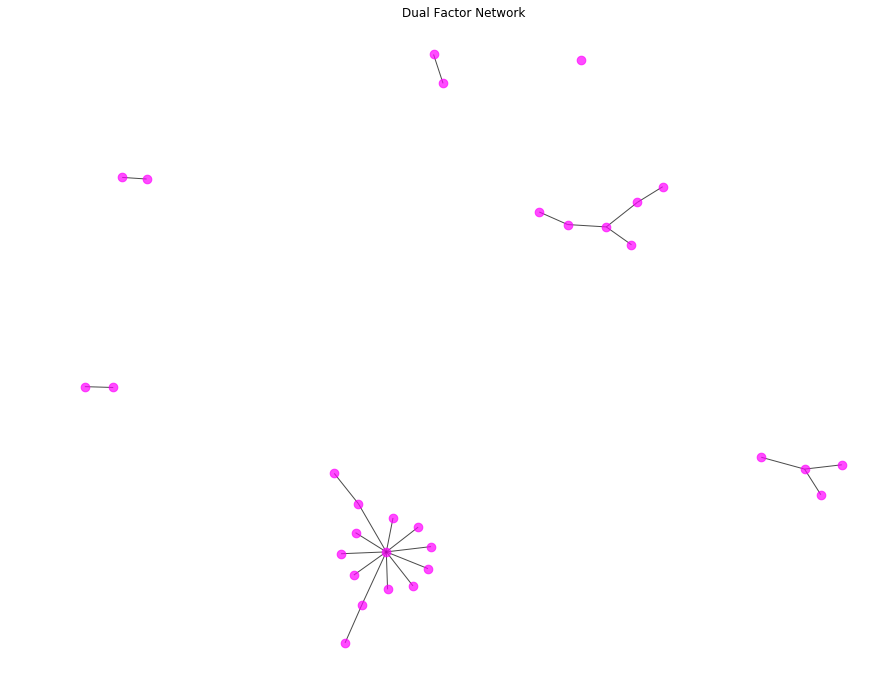

In [21]:
#draw the repressor network graph
plt.figure(figsize=(15, 12))
nx.draw_networkx(G3,
                 pos=nx.spring_layout(G3), 
                 node_color='magenta',
                 edge_color='black',
                 node_size=75,
                 with_labels=False,
                 alpha=.7
                 )
plt.title('Dual Factor Network')
plt.axis('off')
plt.show()

In [22]:
df.head()

,id,gene,transcripion_name,operon_name,operon_number,transcription_number,regulation_type
0,1,aceBAK,AcrR,acrAB,3,4,repressor
1,2,acnA,Ada,ada-alkB,6,6,dual
2,3,acrAB,Ada,aidB,11,6,activator
3,4,acrR,Ada,alkA,14,6,activator
4,5,acs,AdiY,adiA,8,9,activator


In [56]:
from pyvis import network as net

gnet = net.Network(notebook=True, bgcolor='#222222', font_color='white', width='900px', height='900px')
gnet.barnes_hut()

gnet.from_nx(G)
neighbor_map = gnet.get_adj_list()

for node in df['id']:
    if node in gnet.nodes:
        gnet.node[node]['Gene'] = df.loc[df['id']==node,'gene'].values[0]
        gnet.node[node]['Regulation Type'] = df.loc[df['id']==node,'regulation_type'].values[0]
        gnet.node[node]['Transcription Factor Name'] = df.loc[df['id']==node,'transcripion_name'].values[0]
        gnet.node[node]['Operon Name'] = df.loc[df['id']==node,'operon_name'].values[0]
    
gnet.prep_notebook()
gnet.show('genes.html')

In [24]:
nodes, edges, height, width, options = gnet.get_network_data()

In [69]:
from networkx.algorithms import community

community_generator = community.girvan_newman(G)
top_level_communities = next(community_generator)
next_level_communities = next(community_generator)

k=2

for communities in itertools.islice(community_generator, k):
    print(tuple(sorted(c) for c in communities))

([3, 4], [1, 5, 6, 7, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 44, 49, 50, 56, 57, 60, 63, 66, 72, 73, 76, 82, 83, 85, 86, 87, 88, 89, 90, 92, 94, 95, 96, 97, 107, 108, 110, 112, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182, 183, 190, 191, 197, 200, 202, 203, 209, 210, 215, 216, 217, 228, 229, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 245, 246, 255, 258, 267, 270, 271, 272, 273, 274, 275, 276, 277, 280, 282, 283, 284, 285, 286, 287, 289, 295, 296, 298, 308, 309, 312, 314, 315, 317, 318, 325, 326, 336, 338, 345, 351, 357, 361, 362, 369, 373, 374, 375, 382, 387, 388, 390, 395, 414, 416, 423], [8, 9], [15, 356], [25, 26, 27, 28, 29, 30, 58], [39, 40], [42, 43], [46, 47, 48], [51, 52, 53], [54, 55], [59, 77, 78, 79, 80, 81, 364, 368], [64, 65, 93, 103, 131, 132, 133, 134, 135, 136, 137, 138

In [52]:
print('Coverage:', community.coverage(G, next_level_communities))
print('Performance:', community.performance(G, next_level_communities))
print('Modularity:', community.modularity(G, next_level_communities))

Coverage: 0.9858156028368794
Performance: 0.5980120203421174
Modularity: 0.4299666348104128


In [65]:
import itertools
k=2
for communities in itertools.islice(community_generator, k):
    print(tuple(sorted(c) for c in communities))